<a href="https://colab.research.google.com/github/zihe-yan/Thinking_with_DL_Final/blob/Zihe/Tabular_Data_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audience Preference and Movie Features

Can movie features influence the rating by gender?

## Load Data

Two data are imported separately.
1. Convokit
2. Corresponding IMDB rating

### Convokit

In [ ]:
try:
    import convokit
except ModuleNotFoundError:
    !pip install convokit

In [ ]:
from convokit import Corpus, download
import pandas as pd

In [ ]:
# download movie dialogs
movie_dialogs = Corpus(filename=download("movie-corpus"))
# summary of the data
movie_dialogs.print_summary_stats()

Number of Speakers: 9035
Number of Utterances: 304713
Number of Conversations: 83097


In [ ]:
speakers = movie_dialogs.get_speakers_dataframe().reset_index()
utterance = movie_dialogs.get_utterances_dataframe().reset_index()
convo = movie_dialogs.get_conversations_dataframe().reset_index()

In [ ]:
# try to merge conversational and utterance dataset
corpus_sub = pd.merge(utterance, convo, left_on='conversation_id', right_on='id')
# drop unnessary colmuns
corpus_sub = corpus_sub.drop(['vectors_x','vectors_y','meta.movie_id'], axis=1)

# the second merge, speaker dataset into utterance
corpus = pd.merge(corpus_sub, speakers, left_on='speaker', right_on='id')
corpus = corpus.drop(['vectors','meta.movie_idx_y','meta.movie_name_y'], axis=1)

### IMDB dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
info = pd.read_csv('drive/MyDrive/UChicago/Deep Learning/IMDB_infos.csv')
info = info[['index','budget','openWeek', 'WorldGross','IMDB_male','IMDB_female']]
info.head()

,index,budget,openWeek,WorldGross,IMDB_male,IMDB_female
0,m0,30000000.0,8330681.0,53478579.0,7.0,7.8
1,m1,47000000.0,3002680.0,7191399.0,6.4,6.4
2,m10,6000000.0,63979.0,6330054.0,6.9,6.7
3,m100,27000000.0,4739913.0,25893810.0,6.8,6.9
4,m101,90000000.0,6712361.0,60289912.0,7.9,7.7


## Create Tabular Data

The first step is to create gender categorical variables, indexing by the credit position.

### Gender variables

In [ ]:
# filter out all columns without credit position and count the distribution
speakers.loc[speakers['meta.credit_pos'] == '?'] = 99
speakers['meta.credit_pos'] = speakers['meta.credit_pos'].astype(int)
speakers = speakers[speakers['meta.credit_pos']<=5]
speakers.groupby('meta.credit_pos').size()

meta.credit_pos
1    497
2    443
3    352
4    268
5    211
dtype: int64

We can see that not many movies have five credit position. 

To expand the table into what we need, we will firstly create an empty table. By matching it with each credit position, we can fill them it by iteration.

In [ ]:
# get an index of movies that have credit position
tabular = pd.DataFrame(speakers['meta.movie_idx'].value_counts())
tabular = tabular[tabular['meta.movie_idx'] <= 5]

# create an empty table with all empty values, name it as gender.
columns = ['gender_1','gender_2','gender_3','gender_4','gender_5']
index = tabular.index
gender = pd.DataFrame(columns=columns, index=index)

# match each character's gender and write it in the gender dataframe.
for i in tabular.index:
  num_gender = speakers[speakers['meta.movie_idx']==i]['meta.gender'].to_list()
  length = len(num_gender)
  gender.loc[i].iloc[:length].replace(gender[gender.index==i].values.flatten()[:length].tolist(), num_gender, inplace=True)

Here is what the dataframe looks like.

In [ ]:
gender.sample(5)

,gender_1,gender_2,gender_3,gender_4,gender_5
m81,m,m,NaN,NaN,NaN
m157,m,NaN,NaN,NaN,NaN
m121,f,f,f,NaN,NaN
m542,m,NaN,NaN,NaN,NaN
m55,m,m,m,NaN,NaN


### Genre Variables

1. Calculate length of variables
2. Create corresponding columns
3. Iterate each movie and mark them in the new table

In [ ]:
# try to join the tabular data with the convo table
tabular = tabular.reset_index().drop('meta.movie_idx',axis=1)
tabular_right = convo.groupby('meta.movie_idx').first().reset_index()

genre = pd.merge(tabular, tabular_right, left_on='index', right_on='meta.movie_idx')[['index','meta.genre']]

genre['drama'] = genre['meta.genre'].str.contains('drama') #289
genre['romance'] = genre['meta.genre'].str.contains('romance') #126
genre['comedy'] = genre['meta.genre'].str.contains('comedy') #146
genre['adventure'] = genre['meta.genre'].str.contains('adventure') #92
genre['fantasy'] = genre['meta.genre'].str.contains('fantasy') #64
genre['sci-fi'] = genre['meta.genre'].str.contains('sci-fi') #94
genre['thriller'] = genre['meta.genre'].str.contains('thriller') #242
genre['crime'] = genre['meta.genre'].str.contains('crime')
genre['mystery'] = genre['meta.genre'].str.contains('mystery')

In [ ]:
genre.head()

,index,meta.genre,drama,romance,comedy,adventure,fantasy,sci-fi,thriller,crime,mystery
0,m94,"['drama', 'romance', 'sport']",True,True,False,False,False,False,False,False,False
1,m522,['comedy'],False,False,True,False,False,False,False,False,False
2,m444,"['comedy', 'romance', 'drama']",True,True,True,False,False,False,False,False,False
3,m445,"['adventure', 'comedy']",False,False,True,True,False,False,False,False,False
4,m88,"['comedy', 'drama', 'music', 'romance']",True,True,True,False,False,False,False,False,False


### Plot Distribution

1. Plot the genre variables
2. Plot the gender variables

In [ ]:
import matplotlib.pyplot as plt

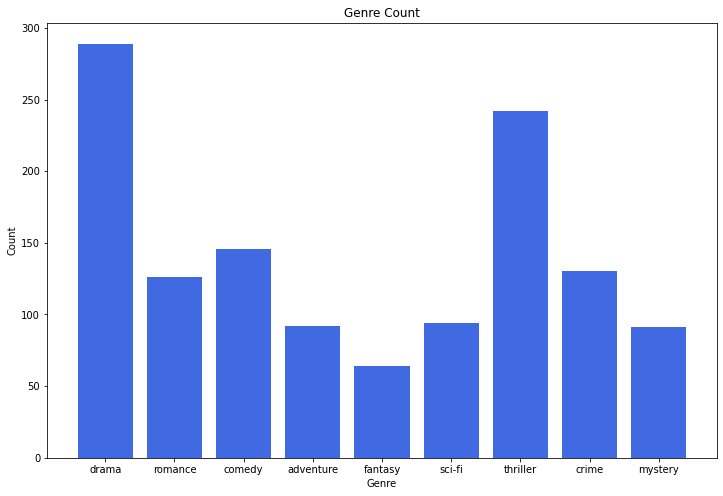

In [ ]:
# make distribution table
distribution = pd.DataFrame((genre[["drama","romance","comedy","adventure","fantasy",
        "sci-fi","thriller","crime","mystery"]] == True).sum(), columns = ['Count'])

# plot the distribution
fig, ax = plt.subplots(figsize=(12,8))

plt.bar(distribution.index, distribution.Count,
        color='royalblue')

plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Genre Count")

plt.savefig('drive/MyDrive/UChicago/Deep Learning/Genre_Count.png')

Having plotted the genre distribution, next we will plot the distribution of male and female characters.

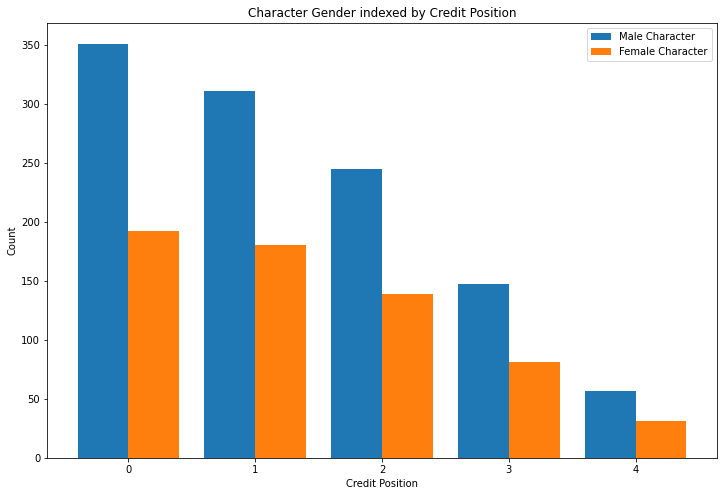

In [ ]:
# make distribution table
distribution = pd.DataFrame((gender[["gender_1","gender_2","gender_3","gender_4","gender_5"]] == 'm').sum(), columns = ['Count_male'])
distribution['count_female'] = (gender[["gender_1","gender_2","gender_3","gender_4","gender_5"]] == 'f').sum()

fig, ax = plt.subplots(figsize=(12,8))

X_axis = np.arange(5)
  
plt.bar(X_axis - 0.2, distribution['Count_male'], 0.4, label = 'Male Character')
plt.bar(X_axis + 0.2, distribution['count_female'], 0.4, label = 'Female Character')
  
#plt.xticks(X_axis, distribution)
plt.xlabel("Credit Position")
plt.ylabel("Count")
plt.title("Character Gender indexed by Credit Position")
plt.legend()

plt.savefig('drive/MyDrive/UChicago/Deep Learning/Gender_Count.png')

### Combine Three Tables

We will combine three dataframes together, however, due to the limited size of the data, we will drop several columns along the way.

In [ ]:
# gender and genre
gender = gender.reset_index()
tabular = pd.merge(gender, genre, left_on='index', right_on='index')

# join other data from convokit
tabular_right = convo.groupby('meta.movie_idx').first().reset_index()
final_table = pd.merge(tabular, tabular_right, left_on='index', right_on='meta.movie_idx').drop(['vectors',
                                                                                                 'id','meta.genre_y',
                                                                                                 'meta.movie_name',
                                                                                                 'meta.movie_idx',
                                                                                                 'meta.genre_x',
                                                                                                 'meta.release_year'],axis=1)

# join the IMDB scraped data
final_table = pd.merge(final_table, info, left_on='index', right_on='index')
final_table = final_table.drop(['gender_2','gender_3','gender_4','gender_5'], axis=1)

In [ ]:
final_table.head()

,index,gender_1,drama,romance,comedy,adventure,fantasy,sci-fi,thriller,crime,mystery,meta.rating,meta.votes,budget,openWeek,WorldGross,IMDB_male,IMDB_female
0,m94,m,True,True,False,False,False,False,False,False,False,8.20,25871,2125000.0,NaN,NaN,8.0,7.8
1,m522,m,False,False,True,False,False,False,False,False,False,8.40,68749,2883848.0,NaN,195088.0,8.2,8.4
2,m444,m,True,True,True,False,False,False,False,False,False,7.10,15879,15000000.0,127599.0,80642217.0,7.0,7.4
3,m445,m,False,False,True,True,False,False,False,False,False,8.40,157683,NaN,45487.0,1940906.0,8.2,8.2
4,m88,f,True,True,True,False,False,False,False,False,False,7.60,70464,30000000.0,6429107.0,47126295.0,7.5,7.3


## Clean the Table (Preprocessing)

1. Impute missing data
2. transform data labels
3. Normalization

In [ ]:
# impute the missing data.
final_table['budget'].fillna(final_table['budget'].mean(), inplace = True)
final_table['openWeek'].fillna(final_table['openWeek'].mean(), inplace = True)
final_table['WorldGross'].fillna(final_table['WorldGross'].mean(), inplace = True)
final_table['IMDB_male'].fillna(final_table['IMDB_male'].mean(), inplace = True)
final_table['IMDB_female'].fillna(final_table['IMDB_female'].mean(), inplace = True)

print(final_table.isnull().sum())

index          0
gender_1       0
drama          0
romance        0
comedy         0
adventure      0
fantasy        0
sci-fi         0
thriller       0
crime          0
mystery        0
meta.rating    0
meta.votes     0
budget         0
openWeek       0
WorldGross     0
IMDB_male      0
IMDB_female    0
dtype: int64


After imputing the missing value with mean value, we will convert the bool features into numeric. Here we need to consider the different encodings in gender and genre and take different actions.

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
# change feature names for convinient purpose
final_table.rename(columns = {'meta.rating':'rating', 'meta.votes':'votes', 'sci-fi': 'scifi'}, inplace = True)

# convert gender label into dummy variables
final_table['gender_1'] = final_table['gender_1'].replace({'m':True,'f':False})

In [ ]:
final_table.head()

,index,gender_1,drama,romance,comedy,adventure,fantasy,scifi,thriller,crime,mystery,rating,votes,budget,openWeek,WorldGross,IMDB_male,IMDB_female
0,m94,True,True,True,False,False,False,False,False,False,False,8.20,25871,2.125000e+06,1.092559e+07,1.071614e+08,8.0,7.8
1,m522,True,False,False,True,False,False,False,False,False,False,8.40,68749,2.883848e+06,1.092559e+07,1.950880e+05,8.2,8.4
2,m444,True,True,True,True,False,False,False,False,False,False,7.10,15879,1.500000e+07,1.275990e+05,8.064222e+07,7.0,7.4
3,m445,True,False,False,True,True,False,False,False,False,False,8.40,157683,3.030713e+07,4.548700e+04,1.940906e+06,8.2,8.2
4,m88,False,True,True,True,False,False,False,False,False,False,7.60,70464,3.000000e+07,6.429107e+06,4.712630e+07,7.5,7.3


In [ ]:
final_table['gender_1'].value_counts()

True     351
False    192
Name: gender_1, dtype: int64

Before analyzing the table data, considering the different scales of variables, we will normalize other numerical variables.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
final_table.iloc[:, 11:16] = scaler.fit_transform(final_table.iloc[:, 11:16])

In [ ]:
final_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 543 entries, 0 to 542
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        543 non-null    object 
 1   gender_1     543 non-null    bool   
 2   drama        543 non-null    bool   
 3   romance      543 non-null    bool   
 4   comedy       543 non-null    bool   
 5   adventure    543 non-null    bool   
 6   fantasy      543 non-null    bool   
 7   scifi        543 non-null    bool   
 8   thriller     543 non-null    bool   
 9   crime        543 non-null    bool   
 10  mystery      543 non-null    bool   
 11  rating       543 non-null    float64
 12  votes        543 non-null    float64
 13  budget       543 non-null    float64
 14  openWeek     543 non-null    float64
 15  WorldGross   543 non-null    float64
 16  IMDB_male    543 non-null    float64
 17  IMDB_female  543 non-null    float64
dtypes: bool(10), float64(7), object(1)
memory usage: 4

In [ ]:
final_table.describe()

,rating,votes,budget,openWeek,WorldGross,IMDB_male,IMDB_female
count,5.430000e+02,5.430000e+02,5.430000e+02,5.430000e+02,5.430000e+02,543.000000,543.000000
mean,1.574349e-16,1.022305e-17,-9.635223e-17,-3.424721e-17,4.416357e-17,6.938930,7.012915
std,1.000922e+00,1.000922e+00,1.000922e+00,1.000922e+00,1.000922e+00,1.058866,0.959925
min,-3.750781e+00,-8.298313e-01,-9.824773e-01,-8.500363e-01,-6.547987e-01,2.800000,2.700000
25%,-5.658237e-01,-6.375519e-01,-7.562294e-01,-6.767661e-01,-5.546080e-01,6.400000,6.500000
50%,1.561001e-01,-3.808720e-01,-2.370890e-01,-1.072050e-01,-3.357782e-01,7.100000,7.200000
75%,7.506255e-01,2.689193e-01,3.144976e-01,4.137873e-02,3.762930e-02,7.700000,7.700000
max,1.939676e+00,5.779935e+00,5.733025e+00,8.087669e+00,1.279829e+01,9.200000,9.000000


## Regression Model

In [ ]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### IMDB Female Rating with Movie Features

In [ ]:
import statsmodels.api as sm
from patsy import dmatrices

y, X = dmatrices('IMDB_female ~ gender_1 + drama + romance + comedy + adventure + fantasy + scifi + thriller + crime + mystery + rating + votes + budget + openWeek + WorldGross', data=final_table, return_type='dataframe')

mod = sm.OLS(y, X, hasconst=None)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            IMDB_female   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     296.4
Date:                Mon, 30 May 2022   Prob (F-statistic):          2.04e-245
Time:                        23:36:31   Log-Likelihood:                -138.33
No. Observations:                 543   AIC:                             308.7
Df Residuals:                     527   BIC:                             377.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.9866      0.04

### IMDB Male Rating with Movie Features

In [ ]:
y, X = dmatrices('IMDB_male ~ gender_1 + drama + romance + comedy + adventure + fantasy + scifi + thriller + crime + mystery + rating + votes + budget + openWeek + WorldGross', data=final_table, return_type='dataframe')

mod_male = sm.OLS(y, X, hasconst=None)
res = mod_male.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              IMDB_male   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1215.
Date:                Mon, 30 May 2022   Prob (F-statistic):               0.00
Time:                        23:37:01   Log-Likelihood:                 168.70
No. Observations:                 543   AIC:                            -305.4
Df Residuals:                     527   BIC:                            -236.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.9326      0.02

### Male and Female Distinction

In [ ]:
# create new variables
final_table['distinction'] = final_table.apply(lambda x: x['IMDB_male']-x['IMDB_female'],axis=1)

y, X = dmatrices('distinction ~ gender_1 + drama + romance + comedy + adventure + fantasy + scifi + thriller + crime + mystery + rating + votes + budget + openWeek + WorldGross', data=final_table, return_type='dataframe')

mod_male = sm.OLS(y, X, hasconst=None)
res = mod_male.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            distinction   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     11.88
Date:                Tue, 31 May 2022   Prob (F-statistic):           2.03e-25
Time:                        04:26:24   Log-Likelihood:                -56.775
No. Observations:                 543   AIC:                             145.5
Df Residuals:                     527   BIC:                             214.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0540      0.03

It seems that simply subtracting the variables can't tell the differences between women preferences and men preferences.

## Neural Network Models

We will plug the data into three neural networks, (1) baseline model, (2) wide and deep model, (3) deep and cross model. But before that, we will add additional preprocessing steps.

### Preprocssing and Input

In [ ]:
import numpy as np

In [ ]:
# create classification labels
final_table['male_class'] = final_table['IMDB_male'] > 6.9

final_table = final_table.drop(['index','IMDB_male', 'IMDB_female'],axis=1)

final_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 543 entries, 0 to 542
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   gender_1    543 non-null    bool   
 1   drama       543 non-null    bool   
 2   romance     543 non-null    bool   
 3   comedy      543 non-null    bool   
 4   adventure   543 non-null    bool   
 5   fantasy     543 non-null    bool   
 6   scifi       543 non-null    bool   
 7   thriller    543 non-null    bool   
 8   crime       543 non-null    bool   
 9   mystery     543 non-null    bool   
 10  rating      543 non-null    float64
 11  votes       543 non-null    float64
 12  budget      543 non-null    float64
 13  openWeek    543 non-null    float64
 14  WorldGross  543 non-null    float64
 15  male_class  543 non-null    bool   
dtypes: bool(11), float64(5)
memory usage: 31.3 KB


Because network needs another form of data, then we will also conduct additional processing steps.

In [ ]:
# gender labels
le = LabelEncoder()
final_table['gender_1'] = le.fit_transform(final_table['gender_1'])
final_table['male_class'] = le.fit_transform(final_table['male_class'])

# genre labels
final_table[['gender_1','drama',
             'romance',
             'comedy',
             'adventure',
             'fantasy','scifi',
             'thriller','crime','mystery','male_class']] = final_table[['gender_1','drama',
                                                           'romance','comedy',
                                                           'adventure','fantasy',
                                                           'scifi','thriller',
                                                           'crime','mystery','male_class']].astype(str)

In [ ]:
final_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 543 entries, 0 to 542
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   gender_1    543 non-null    object 
 1   drama       543 non-null    object 
 2   romance     543 non-null    object 
 3   comedy      543 non-null    object 
 4   adventure   543 non-null    object 
 5   fantasy     543 non-null    object 
 6   scifi       543 non-null    object 
 7   thriller    543 non-null    object 
 8   crime       543 non-null    object 
 9   mystery     543 non-null    object 
 10  rating      543 non-null    float64
 11  votes       543 non-null    float64
 12  budget      543 non-null    float64
 13  openWeek    543 non-null    float64
 14  WorldGross  543 non-null    float64
 15  male_class  543 non-null    object 
dtypes: float64(5), object(11)
memory usage: 72.1+ KB


In [ ]:
# train, test split
train_splits = []
test_splits = []

for _, group_data in final_table.groupby("male_class"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.85
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print(f"Train split size: {len(train_data.index)}")
print(f"Test split size: {len(test_data.index)}")

train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

Train split size: 458
Test split size: 85


In [ ]:
CSV_HEADER = ['gender_1','drama','romance','comedy','adventure','fantasy','scifi',
              'thriller','crime','mystery','rating','votes','budget',
              'openWeek','WorldGross','male_class']

TARGET_FEATURE_NAME = "male_class"

TARGET_FEATURE_LABELS = [0,1]

NUMERIC_FEATURE_NAMES = ["rating", "votes",'budget','openWeek', 'WorldGross']

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "gender_1": list(final_table["gender_1"].unique()),
    "drama": list(final_table["drama"].unique()),
    "romance": list(final_table["romance"].unique()),
    "comedy": list(final_table["comedy"].unique()),
    "adventure": list(final_table["adventure"].unique()),
    "fantasy": list(final_table["fantasy"].unique()),
    "scifi": list(final_table["scifi"].unique()),
    "thriller": list(final_table["thriller"].unique()),
    "crime": list(final_table["crime"].unique()),
    "mystery": list(final_table["mystery"].unique())
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0.00] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

### Baseline Model

In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#setup
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()



learning_rate = 0.001
dropout_rate = 0.1
batch_size = 265
num_epochs = 50

hidden_units = [32, 32]

In [ ]:
#create input
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [ ]:
#encode features

from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            index = StringLookup(
                vocabulary=vocabulary, mask_token=None, num_oov_indices=0
            )
            value_index = index(inputs[feature_name])
            if use_embedding:
                embedding_dims = int(math.sqrt(len(vocabulary)))
                embedding_ecoder = layers.Embedding(
                    input_dim=len(vocabulary), output_dim=embedding_dims
                )
                encoded_feature = embedding_ecoder(value_index)
            else:
                onehot_encoder = CategoryEncoding(output_mode="binary")
                onehot_encoder.adapt(index(vocabulary))
                encoded_feature = onehot_encoder(value_index)
        else:
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


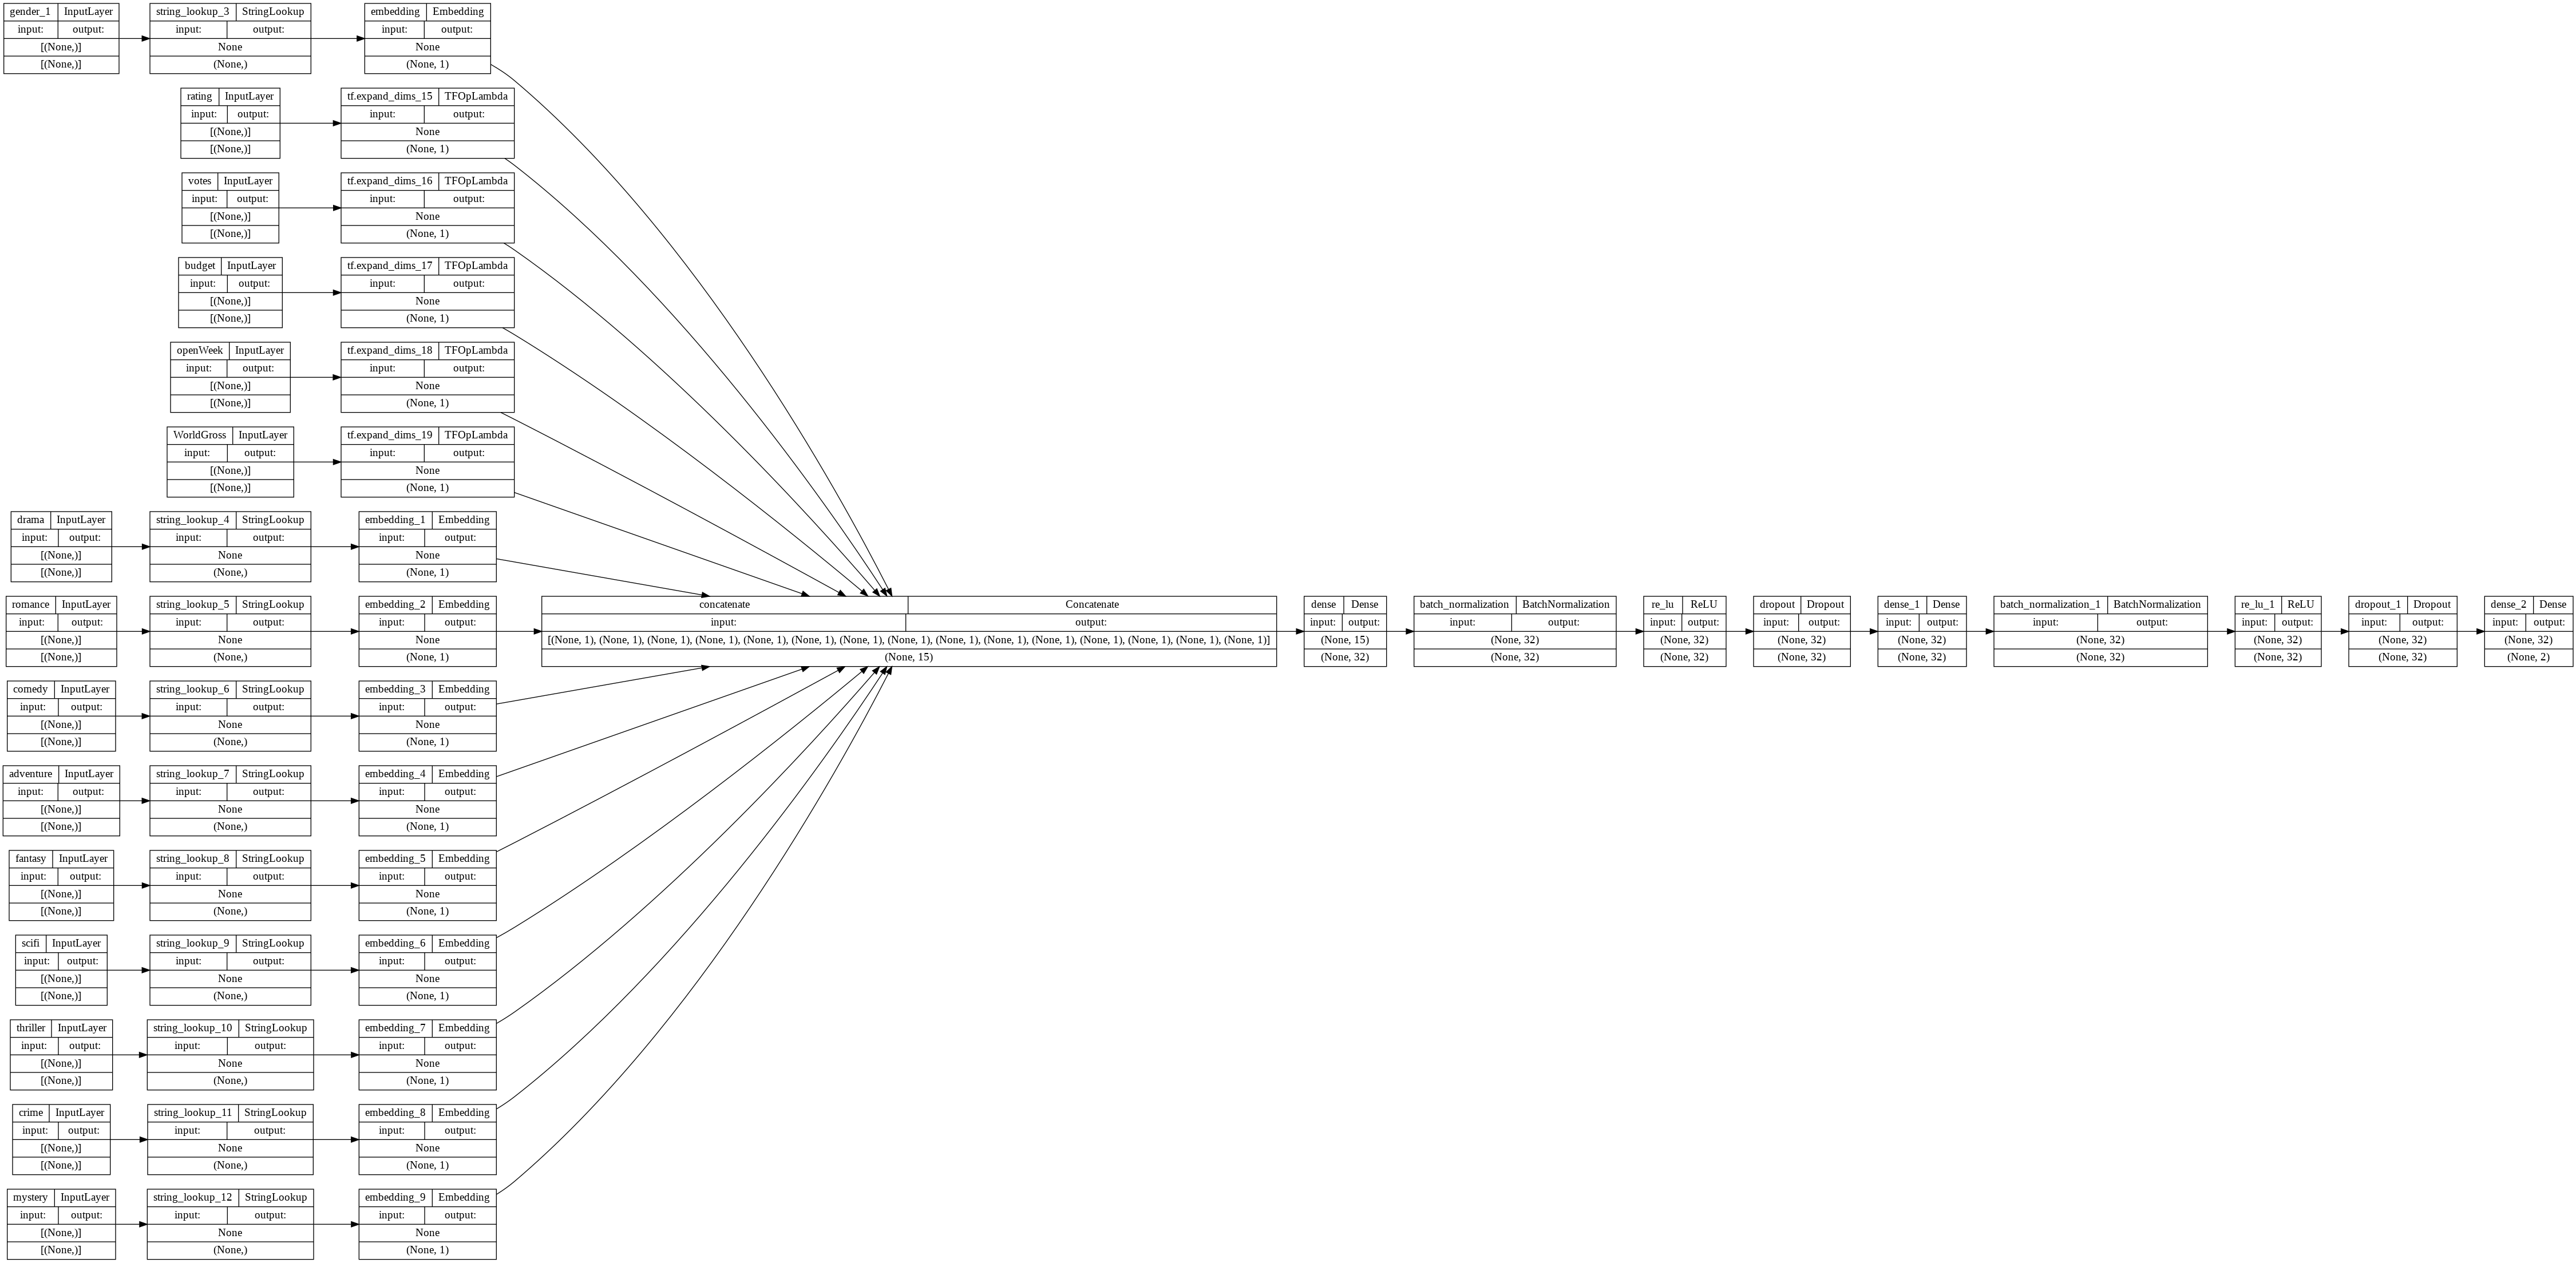

In [ ]:
#baseline model

def create_baseline_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        features = layers.Dense(units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.ReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model()
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

In [ ]:
def run_experiment(model):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)

    test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    _, accuracy = model.evaluate(test_dataset, verbose=0)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [ ]:
run_experiment(baseline_model)

Start training the model...
Epoch 1/50
2/2 [==============================] - 4s 75ms/step - loss: 0.8611 - sparse_categorical_accuracy: 0.5197
Epoch 2/50
2/2 [==============================] - 0s 11ms/step - loss: 0.7508 - sparse_categorical_accuracy: 0.6004
Epoch 3/50
2/2 [==============================] - 0s 10ms/step - loss: 0.6734 - sparse_categorical_accuracy: 0.6266
Epoch 4/50
2/2 [==============================] - 0s 10ms/step - loss: 0.5925 - sparse_categorical_accuracy: 0.7140
Epoch 5/50
2/2 [==============================] - 0s 9ms/step - loss: 0.5789 - sparse_categorical_accuracy: 0.7140
Epoch 6/50
2/2 [==============================] - 0s 10ms/step - loss: 0.5284 - sparse_categorical_accuracy: 0.7751
Epoch 7/50
2/2 [==============================] - 0s 10ms/step - loss: 0.4685 - sparse_categorical_accuracy: 0.8210
Epoch 8/50
2/2 [==============================] - 0s 12ms/step - loss: 0.4341 - sparse_categorical_accuracy: 0.8406
Epoch 9/50
2/2 [=============================

### Wide and Deep

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


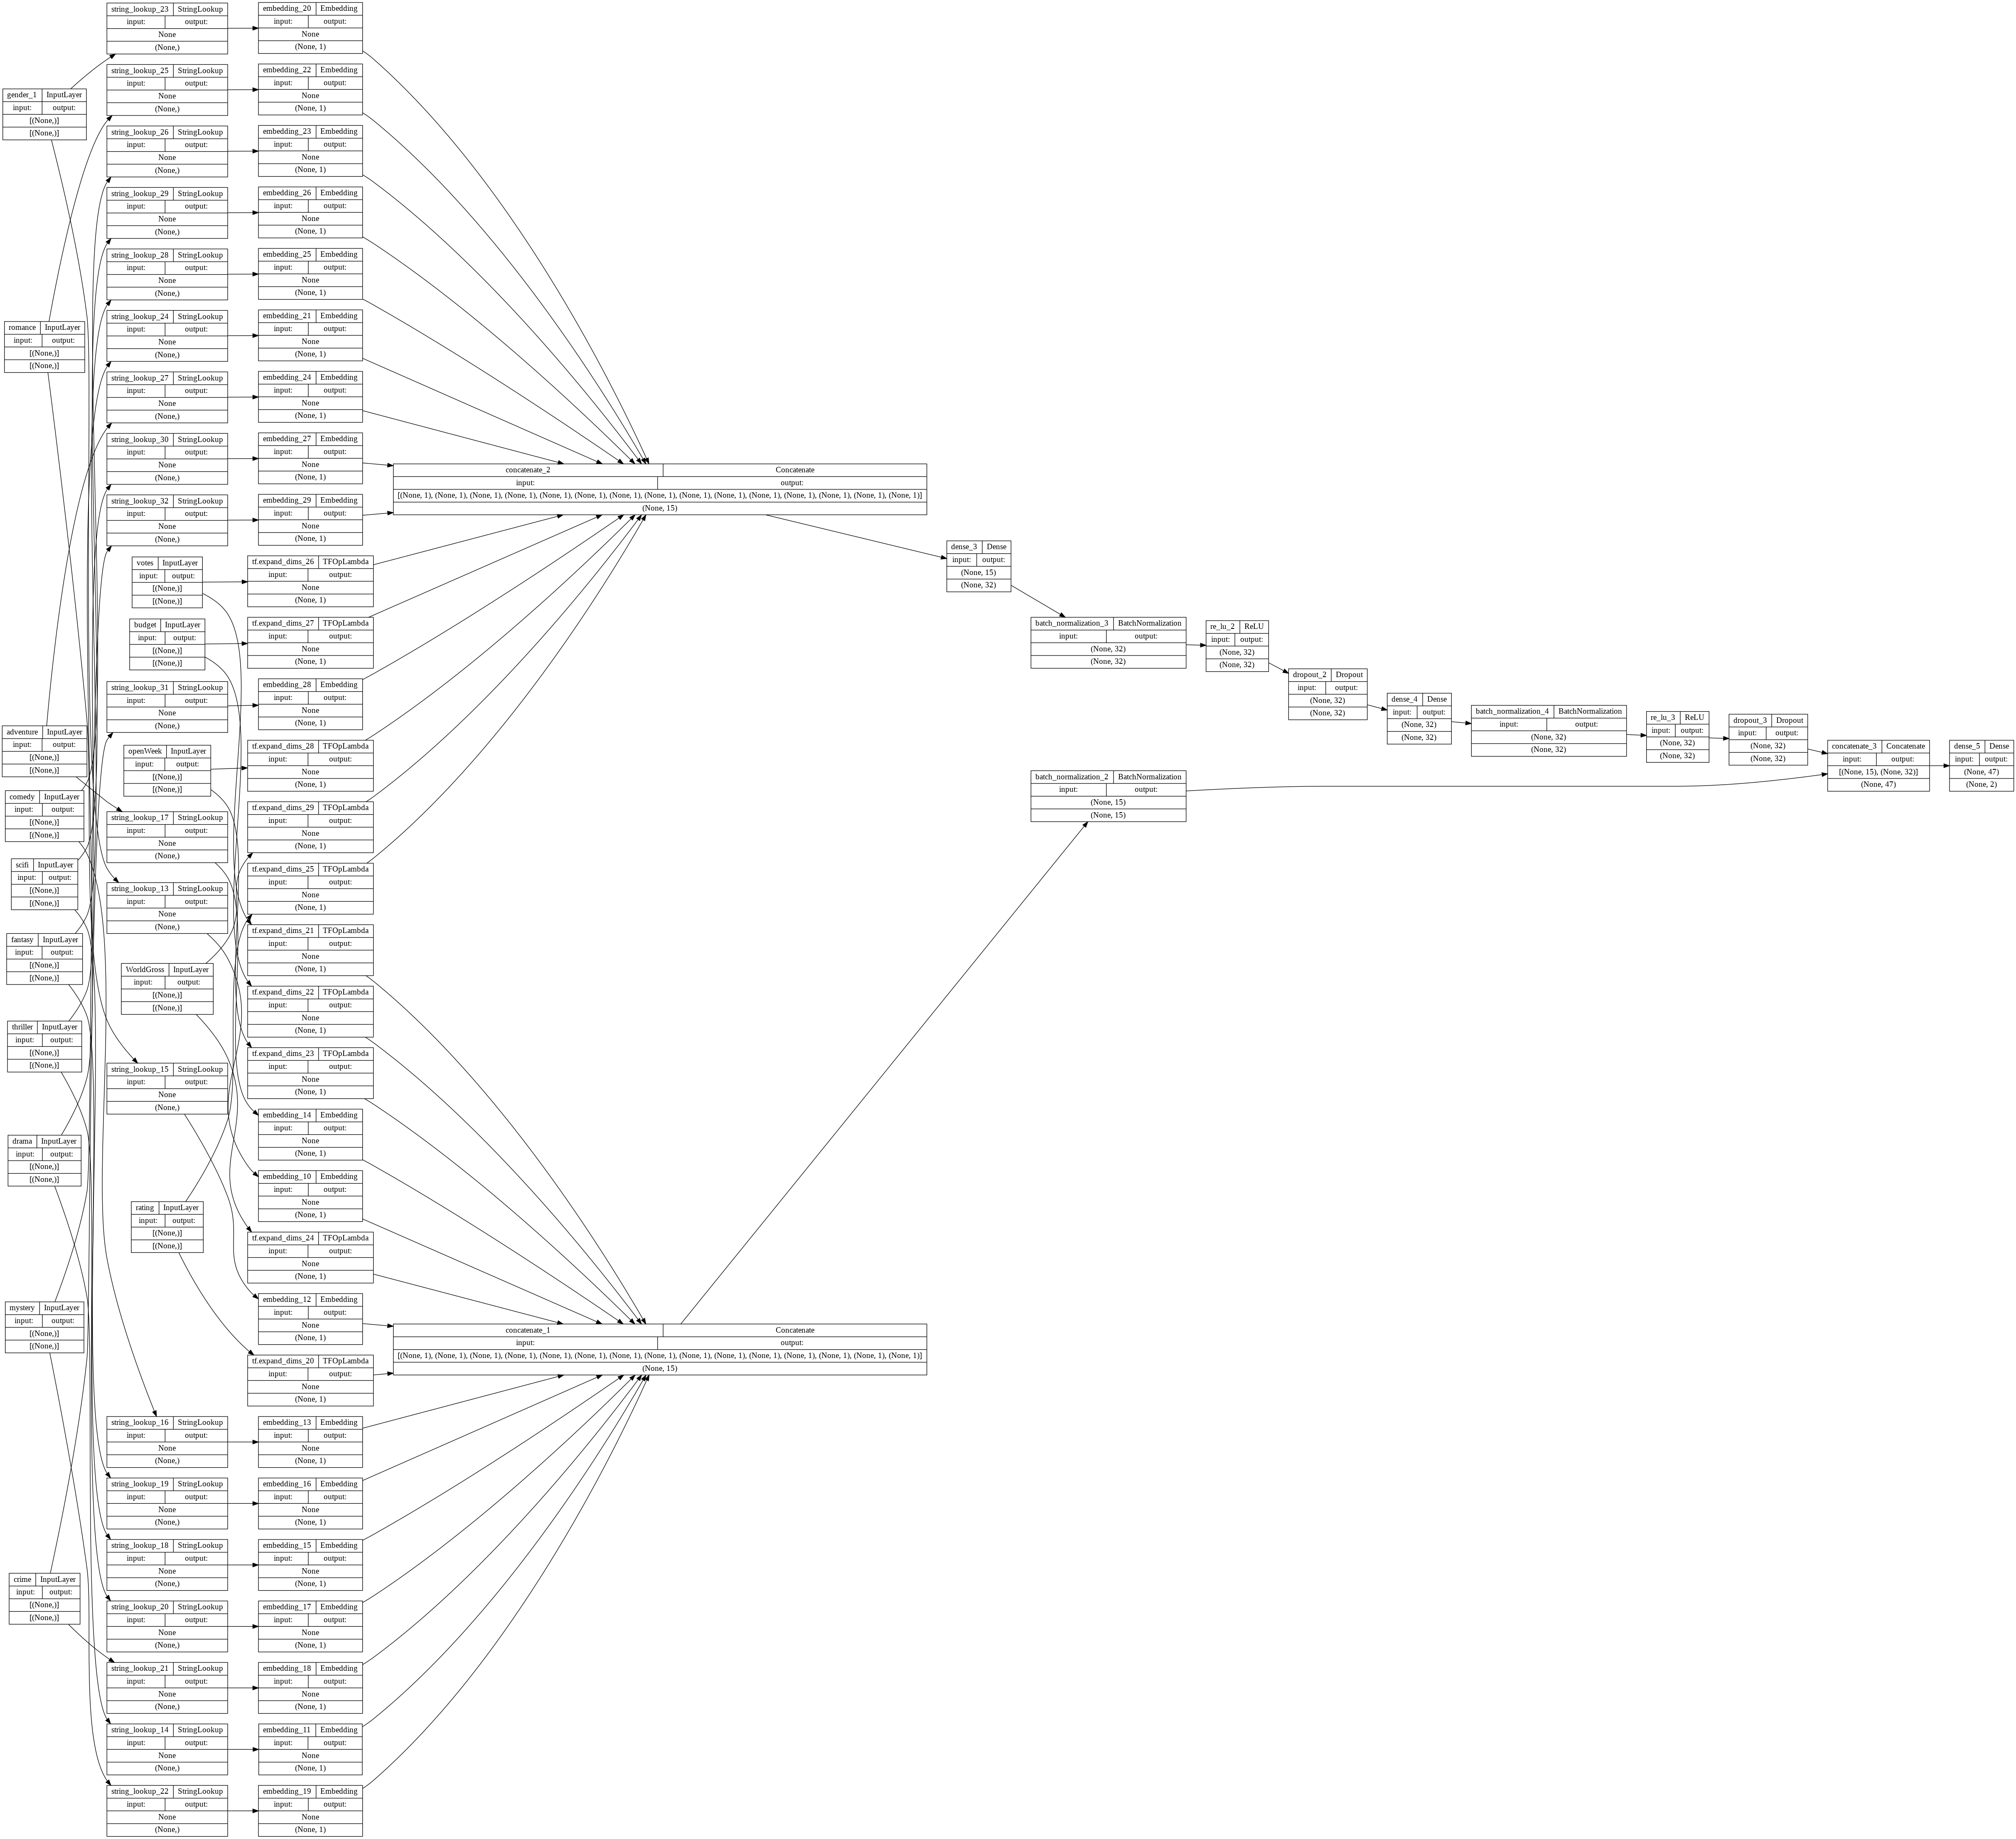

In [ ]:
#wide and deep
def create_wide_and_deep_model():

    inputs = create_model_inputs()
    wide = encode_inputs(inputs, use_embedding=True)
    wide = layers.BatchNormalization()(wide)

    deep = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


wide_and_deep_model = create_wide_and_deep_model()
keras.utils.plot_model(wide_and_deep_model, show_shapes=True, rankdir="LR")

In [ ]:
run_experiment(wide_and_deep_model)

Start training the model...
Epoch 1/50
2/2 [==============================] - 6s 68ms/step - loss: 0.7377 - sparse_categorical_accuracy: 0.6288
Epoch 2/50
2/2 [==============================] - 0s 15ms/step - loss: 0.6579 - sparse_categorical_accuracy: 0.6790
Epoch 3/50
2/2 [==============================] - 0s 14ms/step - loss: 0.6171 - sparse_categorical_accuracy: 0.6943
Epoch 4/50
2/2 [==============================] - 0s 12ms/step - loss: 0.6018 - sparse_categorical_accuracy: 0.7183
Epoch 5/50
2/2 [==============================] - 0s 13ms/step - loss: 0.5881 - sparse_categorical_accuracy: 0.7467
Epoch 6/50
2/2 [==============================] - 0s 12ms/step - loss: 0.5401 - sparse_categorical_accuracy: 0.7598
Epoch 7/50
2/2 [==============================] - 0s 12ms/step - loss: 0.5204 - sparse_categorical_accuracy: 0.7882
Epoch 8/50
2/2 [==============================] - 0s 11ms/step - loss: 0.4934 - sparse_categorical_accuracy: 0.8035
Epoch 9/50
2/2 [============================

### Deep and Cross

In [ ]:
def create_deep_and_cross_model():

    inputs = create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


deep_and_cross_model = create_deep_and_cross_model()
keras.utils.plot_model(deep_and_cross_model, show_shapes=True, rankdir="LR")

In [ ]:
run_experiment(deep_and_cross_model)

Start training the model...
Epoch 1/50
2/2 [==============================] - 4s 66ms/step - loss: 0.9946 - sparse_categorical_accuracy: 0.4039
Epoch 2/50
2/2 [==============================] - 0s 11ms/step - loss: 0.9359 - sparse_categorical_accuracy: 0.4345
Epoch 3/50
2/2 [==============================] - 0s 11ms/step - loss: 0.8533 - sparse_categorical_accuracy: 0.4825
Epoch 4/50
2/2 [==============================] - 0s 12ms/step - loss: 0.7602 - sparse_categorical_accuracy: 0.5415
Epoch 5/50
2/2 [==============================] - 0s 13ms/step - loss: 0.7012 - sparse_categorical_accuracy: 0.5939
Epoch 6/50
2/2 [==============================] - 0s 11ms/step - loss: 0.6345 - sparse_categorical_accuracy: 0.6616
Epoch 7/50
2/2 [==============================] - 0s 12ms/step - loss: 0.5943 - sparse_categorical_accuracy: 0.7052
Epoch 8/50
2/2 [==============================] - 0s 14ms/step - loss: 0.5658 - sparse_categorical_accuracy: 0.7358
Epoch 9/50
2/2 [============================

## Feature Extraction

We are also curious about how the data is going through the model. Because the highest performance model is the wide & deep model, then we will look at it.

In [ ]:
extractor_second_last_layer = keras.Model(inputs=wide_and_deep_model.inputs,
                        outputs=[wide_and_deep_model.layers[-2].output])

In [ ]:
extractor_last_layer = keras.Model(inputs=deep_and_cross_model.inputs,
                        outputs=[deep_and_cross_model.layers[-1].output])

In [ ]:
sample = get_dataset_from_csv(test_data_file, 1)

for data in sample.as_numpy_iterator():
  data_point = data
  break

# look at the data
dict(data_point[0])

{'WorldGross': array([-0.65479875], dtype=float32),
 'adventure': array([b'0'], dtype=object),
 'budget': array([-0.93906415], dtype=float32),
 'comedy': array([b'1'], dtype=object),
 'crime': array([b'0'], dtype=object),
 'drama': array([b'0'], dtype=object),
 'fantasy': array([b'0'], dtype=object),
 'gender_1': array([b'1'], dtype=object),
 'mystery': array([b'0'], dtype=object),
 'openWeek': array([0.], dtype=float32),
 'rating': array([0.8355577], dtype=float32),
 'romance': array([b'1'], dtype=object),
 'scifi': array([b'0'], dtype=object),
 'thriller': array([b'0'], dtype=object),
 'votes': array([-0.7209888], dtype=float32)}

In [ ]:
extractor_second_last_layer(dict(data_point[0]))

<tf.Tensor: shape=(1, 47), dtype=float32, numpy=
array([[ 0.7601593 , -0.73056185, -0.9500787 , -0.03243489, -0.62603515,
        -0.02643818,  0.00302762,  0.07438344,  0.05412148, -0.06420136,
        -0.02274632,  0.02012341,  0.15861939,  0.04350042,  0.04211523,
         0.4148757 ,  0.826289  ,  0.1393886 ,  0.7481382 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.47398344,  0.2453208 ,  0.92211056,
         0.893932  ,  0.42381415,  0.72249943,  0.        ,  0.        ,
         0.        ,  0.        ,  0.4675602 ,  0.        ,  0.        ,
         0.        ,  0.2159076 ,  0.        ,  0.510945  ,  0.        ,
         0.49489686,  0.07431802]], dtype=float32)>

In [ ]:
extractor_last_layer(dict(data_point[0]))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.1638129 , 0.83618706]], dtype=float32)>

Here, we can see that the final layer gives us a probability closer to True in Male class. This means for this set of data point, a male is likely to give higher rating.